## P47 Wormhole
- Ok I might end up using these exports all the way back to like P41, we'll see
- First important thing to do is get wormhole idea working here. 

In [1]:
# ! pip install transformers matplotlib tqdm huggingface_hub

In [2]:
# from huggingface_hub import login
# login()

In [3]:
import torch
from transformers import pipeline
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import copy
from collections import OrderedDict

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

device='cuda'

In [4]:
model_id = "meta-llama/Llama-3.2-1B"
# model_id = "openai-community/gpt2"
# model_id = "google/gemma-3-1b-pt"
# model_id = "gpt2"

In [5]:
# #Only needed for llama random initialization
# config_dict = {
#   "_attn_implementation_autoset": True,
#   "architectures": [
#     "LlamaForCausalLM"
#   ],
#   "attention_bias": False,
#   "attention_dropout": 0.0,
#   "bos_token_id": 128000,
#   "eos_token_id": 128001,
#   "head_dim": 64,
#   "hidden_act": "silu",
#   "hidden_size": 2048,
#   "initializer_range": 0.02,
#   "intermediate_size": 8192,
#   "max_position_embeddings": 131072,
#   "mlp_bias": False,
#   "model_type": "llama",
#   "num_attention_heads": 32,
#   "num_hidden_layers": 16,
#   "num_key_value_heads": 8,
#   "pretraining_tp": 1,
#   "rms_norm_eps": 1e-05,
#   "rope_scaling": {
#     "factor": 32.0,
#     "high_freq_factor": 4.0,
#     "low_freq_factor": 1.0,
#     "original_max_position_embeddings": 8192,
#     "rope_type": "llama3"
#   },
#   "rope_theta": 500000.0,
#   "tie_word_embeddings": True,
#   "torch_dtype": "float32",
#   "transformers_version": "4.50.3",
#   "use_cache": True,
#   "vocab_size": 128256
# }

In [6]:
# Random init
# model_config = GPT2Config() #Full sized model
# model = GPT2LMHeadModel(model_config).to(device) #Ok i should see what happens with full and pretrained model. 
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# # Llama with random initialization
# model_config  = LlamaConfig.from_dict(config_dict)
# model = LlamaForCausalLM(model_config).to(device) 
# tokenizer = AutoTokenizer.from_pretrained(model_id)

#Pretrained
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.eval();

In [7]:
# save_dir='/workspace/apr_24_9'

In [8]:
text = "The capital of France is Paris"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

In [9]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()
print(my_loss.item(), outputs.loss.item())

3.3751838207244873 3.3751838207244873


In [10]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()

paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
print(my_loss.item(), outputs.loss.item(), paris_only_loss)

3.3751838207244873 3.3751838207244873 0.9376916737061879


In [11]:
def get_random_directions(params, seed=None):
    """
    Generate random direction vectors for each parameter tensor.
    
    Args:
        params: List of (name, parameter) tuples from model.named_parameters()
        seed: Random seed for reproducibility
        
    Returns:
        direction: OrderedDict mapping parameter names to random direction tensors
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    direction = OrderedDict()
    for name, param in params:
        if param.requires_grad:
            direction[name] = torch.randn_like(param.data)
    
    return direction

In [12]:
def normalize_direction(direction, params):
    """
    Normalize the direction tensors to match the norm of each parameter tensor.
    
    Args:
        direction: OrderedDict mapping parameter names to direction tensors
        params: List of (name, parameter) tuples from model.named_parameters()
        
    Returns:
        normalized_direction: OrderedDict with normalized direction tensors
    """
    param_dict = OrderedDict(params)
    normalized_direction = OrderedDict()
    
    for name, dir_tensor in direction.items():
        param_norm = torch.norm(param_dict[name].data)
        dir_norm = torch.norm(dir_tensor)
        
        # Avoid division by zero
        if dir_norm > 0:
            normalized_direction[name] = dir_tensor * (param_norm / dir_norm)
        else:
            normalized_direction[name] = dir_tensor
    
    return normalized_direction

### Run once without Training

100%|█████████████████████████████████████████████████████████| 24/24 [00:19<00:00,  1.24it/s]


<Figure size 640x480 with 0 Axes>

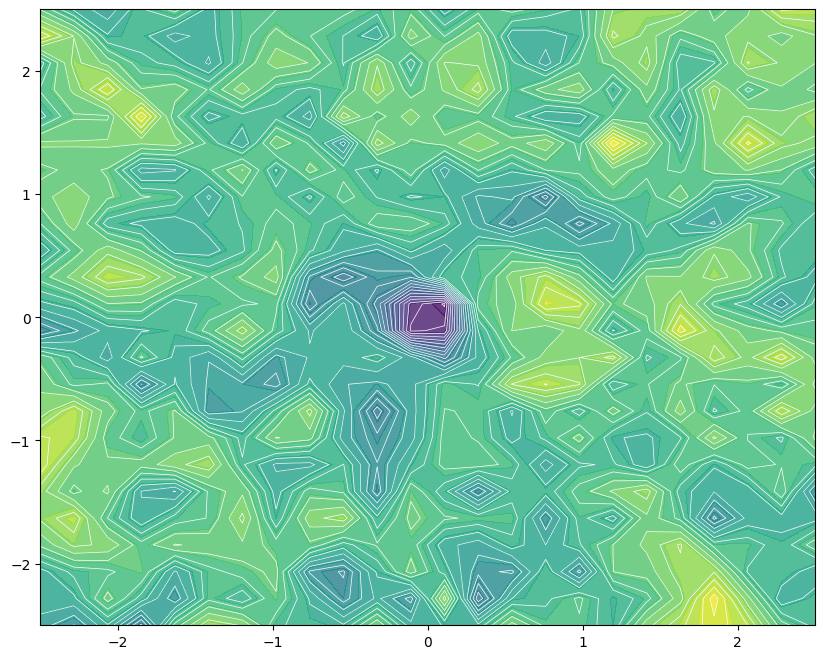

In [13]:
prefix='pretrained_'
filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
# layers_name='all'

layers_name='first_8'
filtered_params = filtered_params[1:73] #First 8 layers - I like this - facorite so far

# layers_name='last_8'
# filtered_params = filtered_params[73:] #Last 8 layers - some nice structue, but yeah more parabolic than I would like

num_points=24
random_seed_1=11
random_seed_2=111

# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=random_seed_1)
direction2 = get_random_directions(filtered_params, seed=random_seed_2)

direction1 = normalize_direction(direction1, filtered_params)
direction2 = normalize_direction(direction2, filtered_params)

original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

alphas=np.linspace(-2.5, 2.5, num_points)
betas=np.linspace(-2.5, 2.5, num_points)
losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        losses.append([])
        for j, beta in enumerate(betas):
            for name, param in model.named_parameters():
                if name in direction1:
                    param.data = original_params[name] + alpha * direction1[name] + beta*direction2[name]
            
            outputs = model(input_ids, labels=input_ids)
            my_probs=F.softmax(outputs.logits, dim=-1)
            paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
            losses[-1].append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

losses=np.array(losses)

plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
contourf = ax.contourf(alphas, betas, losses, 20, cmap='viridis', alpha=0.8)
contour = ax.contour(alphas, betas, losses, 30, colors='white', linewidths=0.5)
# plt.savefig(save_dir +'/'+prefix+str(random_seed_1)+'_'+str(random_seed_2)+'_'+layers_name+'_2d.png')

# plt.clf()
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# surface = ax.plot_surface(alphas, betas, losses, cmap='viridis', edgecolor='none', alpha=0.8)
# plt.savefig(save_dir +'/'+prefix+str(random_seed_1)+'_'+str(random_seed_2)+'_'+layers_name+'_3d.png')

# np.save(save_dir +'/'+prefix+str(random_seed_1)+'_'+str(random_seed_2)+'_'+layers_name, losses)

## Ok now let's get wormhol-ey

- Ok I'm confused, isn't the whole picture going to change as soon as I change my starting point? Or no?
- Ok maybe not in kinda na interesting way -> so if I move to -1, -1 for example, doesn't that just mean I actually need
- to change my testing range from to -1.5 to 3.5 or whatever, and then it should look the same?
- I think that makese sense -> let me noodle for a minutes
- Man I hope the conclusion i drew earlier makes some sense lol - this stuff gets tricky!
- Ok yep that's what happened -> make sense -> these should be fine -> i'll just change my alpha/beta range. 

In [14]:
n_steps=10
trajectory = []
lr=1e-4
output_dir='/home/stephen/backparopagation/apr_24_9'

os.makedirs(output_dir, exist_ok=True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr) #Should try this

In [15]:
#Move away from center
alpha_shift=1
beta_shift=-1

alphas_shifted=alphas-alpha_shift
betas_shifted=betas-beta_shift

for name, param in model.named_parameters():
    if name in direction1 and name in direction2:
        param.data = original_params[name] + alpha_shift * direction1[name] + beta_shift * direction2[name]

original_params_shifted = OrderedDict()
for name, param in filtered_params:
    original_params_shifted[name] = param.data.clone()

In [16]:
alphas_shifted

array([-3.5       , -3.2826087 , -3.06521739, -2.84782609, -2.63043478,
       -2.41304348, -2.19565217, -1.97826087, -1.76086957, -1.54347826,
       -1.32608696, -1.10869565, -0.89130435, -0.67391304, -0.45652174,
       -0.23913043, -0.02173913,  0.19565217,  0.41304348,  0.63043478,
        0.84782609,  1.06521739,  1.2826087 ,  1.5       ])

In [17]:
betas_shifted

array([-1.5       , -1.2826087 , -1.06521739, -0.84782609, -0.63043478,
       -0.41304348, -0.19565217,  0.02173913,  0.23913043,  0.45652174,
        0.67391304,  0.89130435,  1.10869565,  1.32608696,  1.54347826,
        1.76086957,  1.97826087,  2.19565217,  2.41304348,  2.63043478,
        2.84782609,  3.06521739,  3.2826087 ,  3.5       ])

100%|█████████████████████████████████████████████████████████| 24/24 [00:19<00:00,  1.24it/s]


<Figure size 640x480 with 0 Axes>

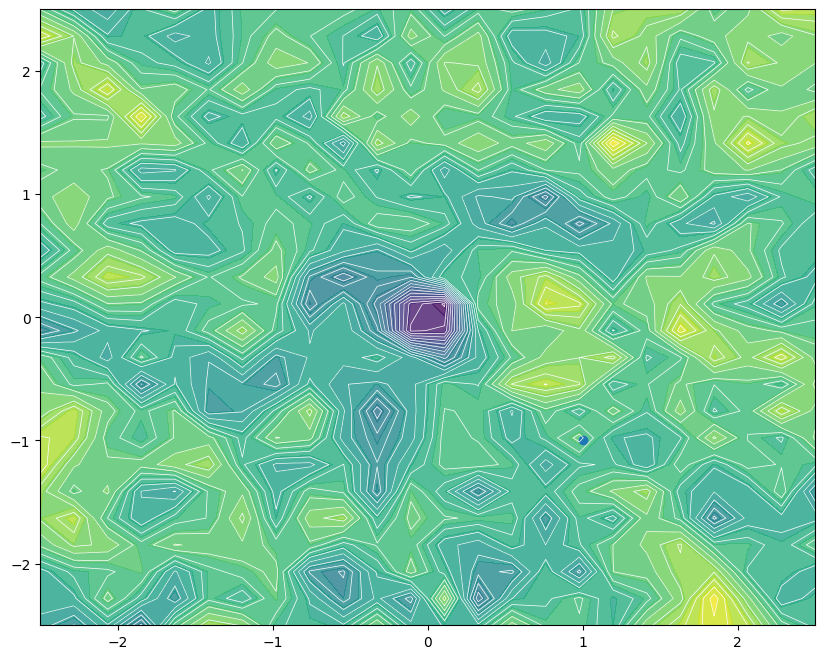

In [18]:
losses=[]
model.eval();
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas_shifted)):
        losses.append([])
        for j, beta in enumerate(betas_shifted):
            for name, param in model.named_parameters():
                if name in direction1:
                    param.data = original_params_shifted[name] + alpha * direction1[name] + beta*direction2[name]
            
            outputs = model(input_ids, labels=input_ids)
            my_probs=F.softmax(outputs.logits, dim=-1)
            paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
            losses[-1].append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original shifted parameters
        if name in original_params: 
            param.data.copy_(original_params_shifted[name])

losses=np.array(losses)

plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
contourf = ax.contourf(alphas, betas, losses, 20, cmap='viridis', alpha=0.8)
contour = ax.contour(alphas, betas, losses, 30, colors='white', linewidths=0.5)
plt.scatter(alpha_shift,beta_shift)

In [19]:
model.train()
optimizer.zero_grad()
outputs = model(**inputs, labels=inputs['input_ids'])
loss = outputs.loss #Ok not just paris loss here -> not sure how much I'm worried about that
loss.backward()
optimizer.step()

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 111.44 MiB is free. Including non-PyTorch memory, this process has 23.07 GiB memory in use. Of the allocated memory 22.73 GiB is allocated by PyTorch, and 41.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
losses=[]
model.eval();
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas_shifted)):
        losses.append([])
        for j, beta in enumerate(betas_shifted):
            for name, param in model.named_parameters():
                if name in direction1:
                    param.data = original_params_shifted[name] + alpha * direction1[name] + beta*direction2[name]
            
            outputs = model(input_ids, labels=input_ids)
            my_probs=F.softmax(outputs.logits, dim=-1)
            paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
            losses[-1].append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original shifted parameters
        if name in original_params: 
            param.data.copy_(original_params_shifted[name])

losses=np.array(losses)

plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
contourf = ax.contourf(alphas, betas, losses, 20, cmap='viridis', alpha=0.8)
contour = ax.contour(alphas, betas, losses, 30, colors='white', linewidths=0.5)
plt.scatter(alpha_shift,beta_shift)